# `mle-scheduler`: Lightweight Cluster/Cloud Job Scheduling 🚂
### Author: [@RobertTLange](https://twitter.com/RobertTLange) [Last Update: November 2021][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/mle-scheduler/blob/main/examples/getting_started.ipynb)

I really dislike having to write Slurm job submission files. It is tedious, I always forget something and copying old templates feelds cumbersome. What if instead there was a tool that would completely get rid of this manual work? A tool that would schedule jobs on different cluster and cloud resources with a minimal and intuitive job/resource description? The `mle-scheduler` package aims to exactly provide such a service for Slurm, OpenGridEngine and Google Cloud Platform VMs. But you can also use the scheduling utilities to launch multiple training runs on a local machine or on a set of SSH servers. It comes with two core functional pillars:

- `MLEJob`: Launches and monitors a single job on a resource (Slurm, OpenGridEngine, GCP, etc.).
- `MLEQueue`: Launches and monitors a queue of jobs with different training configurations or random seeds.

In the remainder of this walkthrough we will first introduce the general logic locally and afterwards go through cluster, SSH and GCP-based jobs. Importantly, the `mle-scheduler` is part of the broader `mle-infrastructure` and comes with a set of handy built-in synergies. We will wrap-up by discussing these.

![](https://github.com/mle-infrastructure/mle-scheduler/blob/main/docs/mle_scheduler_structure.png?raw=true)

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

try:
    import mle_scheduler
except:
    !pip install -q mle-scheduler

Let's start by setting up a simple problem. In the code snippet below we "pseudo"-train a network for 10 epochs and log the training run statistics using [`mle-logging`](https://github.com/mle-infrastructure/mle-logging). I like it - but you can use whatever logging setup you prefer. Importantly, there are three command line arguments that are being parsed at the start-up: `experiment_dir` (the main log directory), `config_fname` (the configuration file to be loaded), `seed_id` (the random number seed for reproduction).

```python
from mle_logging import MLELogger, load_config


def main(experiment_dir: str, config_fname: str, seed_id: int):
    """Example training 'loop' using MLE-Logging."""
    train_config = load_config(config_fname)
    log = MLELogger(
        experiment_dir=experiment_dir,
        config_fname=config_fname,
        seed_id=seed_id,
        time_to_track=["num_epochs"],
        what_to_track=["train_loss", "test_loss"],
    )
    for epoch in range(1, 11):
        train_loss, test_loss = train_your_net(epoch, seed_id, **train_config)
        log.update(
            {"num_epochs": epoch},
            {"train_loss": train_loss, "test_loss": test_loss},
            save=True,
        )
        

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Let's train a network.")
    parser.add_argument("-exp_dir", "--experiment_dir", type=str)
    parser.add_argument("-config", "--config_fname", type=str)
    parser.add_argument("-seed", "--seed_id", type=int, default=1)
    args = vars(parser.parse_args())
    main(args["experiment_dir"], args["config_fname"], args["seed_id"])
```

# Single Job Management with `MLEJob` 🚀

In [24]:
import logging
from mle_scheduler import MLEJob

# Launch python train.py -config base_config_1.yaml -exp_dir logs_single
job = MLEJob(resource_to_run="local",
             job_filename="train.py",
             config_filename="base_config_1.yaml",
             experiment_dir="logs_single",
             logger_level=logging.INFO)

job.run()

0

So how can you specify the resources that you would like to request/schedule for a job? This happens via the `job_arguments` option. It is a dictionary and depending on the resource you would like to run your job on, you have the following options: 

|| Local | SSH | Slurm           | SGE | GCP |
|----|----|------------ | ------------ | ----------- | --------------- |
|`env_name` | ✔️ | ✔️ | ✔️ | ✔️ | ❌

All SSH-server/cloud-based jobs also have their designated `cloud_settings` and `ssh_settings`. You can also manually monitor the status of the a scheduled job:

In [3]:
job_id = job.schedule()
while True:
    status = job.monitor(job_id)
    if status == 0:
        break

# Job Queue Management with `MLEQueue` 🚀🚀🚀

In [73]:
from mle_scheduler import MLEQueue

# Launch a queue of 4 jobs (2 configs x 2 seeds)
# python train.py -config base_config_1.yaml -seed 0 -exp_dir logs_queue/<date>_base_config_1
# python train.py -config base_config_1.yaml -seed 1 -exp_dir logs_queue/<date>_base_config_1
# python train.py -config base_config_2.yaml -seed 0 -exp_dir logs_queue/<date>_base_config_2
# python train.py -config base_config_2.yaml -seed 1 -exp_dir logs_queue/<date>_base_config_2
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_queue",
                 logger_level=logging.INFO)
queue.run()

Output()

You can also control how many jobs to schedule at a given point in time. E.g. if you don't want more than 10 jobs to be running/queued at a time simply add the `max_running_jobs=<num_jobs>` option to the `MLEQueue`.

# Launching a Slurm/GridEngine Cluster-based Job

Now let's talk about launching jobs on your cluster. Importantly, we assume that you are currently on the headnode of your cluster which uses a standard shared file system. [In a future release I plan on adding the option to launch cluster jobs from your local machine - so stay tuned!]

In [ ]:
job_args = {"partition": "standard",
            "env_name": "mle-toolbox",
            "use_conda_venv": True,
            "num_logical_cores": 1,
            "job_name": "test"}

queue = MLEQueue(
    resource_to_run="slurm-cluster",
    job_filename="train.py",
    config_filenames=["base_config_1.yaml", "base_config_2.yaml"],
    random_seeds=[0, 1],
    experiment_dir="logs_queue_slurm",
    job_arguments=job_args,
)
queue.run()

# Launching an SSH Server-based Job

Not every lab may have access to an institution-wide HPC. Instead you may be working with a set of servers, which you can access via SSH. The `mle-scheduler` also allows you to launch jobs in such situations. In order to do so you need to setup passwordless SSH access first. This can for example be done by following [these](https://linuxize.com/post/how-to-setup-passwordless-ssh-login/) instructions and will create a private key on your local machine (e.g. a file called `~.ssh/id_rsa`). You will have to provide this key path as well as your user name, server address, SSH port and the remote code directory in the `ssh_settings` which will be passed to the `MLEJob` & `MLEQueue` instances. This will allow us to establish a SSH connection using the [`paramiko`](https://github.com/paramiko/paramiko) client.

In order to launch a job from your local machine on the remote server you will most likely first need to copy the code directory to the server. This can either be done manually using `scp` or using the `send_code_ssh` function. By default this will send the current working directory to `ssh_settings["remote_dir"]`:

In [65]:
from mle_scheduler.ssh import send_dir_ssh, copy_dir_ssh, delete_dir_ssh

ssh_settings = {"user_name":"RobTLange",
                "pkey_path": '~.ssh/id_rsa',
                "main_server": 'cluster.ml.tu-berlin.de',
                "jump_server": '',
                "ssh_port": 22,
                "remote_dir": "mle-code-dir"}

# scp the current working directory to a mle-code-dir remote
send_dir_ssh(ssh_settings)

Afterwards, we are ready to run the job on the SSH server by `ssh_settings` to our `MLEJob` instance. Once the job is completed the results can be copied back to your local machine using `copy_results_ssh` and the directory path storing the results. Finally, you can use `clean_up_ssh` to delete the previously copied code directory:

In [66]:
job = MLEJob(resource_to_run="ssh-node",
             job_filename="train.py",
             config_filename="base_config_1.yaml",
             experiment_dir="logs_ssh_single",
             job_arguments={"env_name": "mle-toolbox",
                            "use_conda_venv": True},
             ssh_settings=ssh_settings,
             logger_level=logging.INFO)

job.run()

# Copy over the results from the SSH server
copy_dir_ssh(ssh_settings, remote_dir="mle-code-dir/logs_ssh_single")

# Delete the code directory on the SSH server
delete_dir_ssh(ssh_settings)

2021-11-10 20:34:54,260| ERROR   | Could not establish connection from local ('127.0.0.1', 60402) to remote ('cluster.ml.tu-berlin.de', 22) side of the tunnel: 


2021-11-10 20:35:11,119| ERROR   | Could not establish connection from local ('127.0.0.1', 60411) to remote ('cluster.ml.tu-berlin.de', 22) side of the tunnel: 


If you would like to run a queue of jobs, you don't want to copy the same code directory over to the server each time. Instead, the `MLEQueue` will copy the directory (if desired) once at start-up and will delete it again once all jobs have terminated. Furthermore, it will automatically copy the results in to your local execution directory. Note that the error log messages don't have to bother us. They simply come from the ssh client needing a couple of attempts to establish a connection.

In [67]:
ssh_settings["start_up_copy_dir"] = True
ssh_settings["clean_up_remote_dir"] = True

queue = MLEQueue(resource_to_run="ssh-node",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_ssh_queue",
                 job_arguments={"env_name": "mle-toolbox",
                                "use_conda_venv": True},
                 ssh_settings=ssh_settings)

queue.run()

Output()

# Launching a GCP VM-based Job

Finally, let's talk about how to create GCP VM-based jobs using the `mle-scheduler`. This will require you to have already setup Google Cloud SDK and to have created a GCP project and a GCS bucket. Furthermore you will have to provide you `.json` authentication key path. If you don't have one yet, have a look [here](https://cloud.google.com/docs/authentication/getting-started). Alternatively, just make sure that the environment variable `GOOGLE_APPLICATION_CREDENTIALS` is set to the right path.

As for the SSH server jobs we start by copying the code repository in a GCS bucket. In order to know where to sync these files to, you will need to provide the `project_name`, `bucket_name` and the name of the code directory in the bucket. Note that later on all generated results logs will also be stored in this GCS `remote_dir`:

In [8]:
# Import utility to copy local code directory to GCS bucket
from mle_scheduler.cloud.gcp import send_dir_gcp, copy_dir_gcp, delete_dir_gcp

cloud_settings = {
        "project_name": "mle-toolbox",
        "bucket_name": "mle-protocol",
        "remote_dir": "mle-code-dir"
    }

# Send config file to remote machine - independent of code base!
send_dir_gcp(cloud_settings)

At VM startup each of the individual GCP VM instances will `gsync` copy the code and install a `requirements.txt` file in a fresh Python virtual environment. By default the created VMs are [`n1-high-cpu` custom VMs](https://cloud.google.com/compute/docs/general-purpose-machines#n1-high-cpu) since they allow for GPU attachment. The `N1` VMs allow for 1, 2, 4, 8, 16, 32 & 48 logical cores (x2 with hyperthreading) and up to 624 GB of memory. Right now the GCP `MLEJob` will also by default setup a `c1-deeplearning-tf-2-4-cu110-v20210414-debian-10` image from the `ml-images` family, which comes with CUDA 11.0 drivers ready to go. In the future I plan on adding more flexibility to specify resource requests through the `mle-scheduler` and to support TPU VMs.

In [10]:
job_args = {
    "use_tpus": 0,
    "num_gpus": 0,
    "gpu_type": "nvidia-tesla-v100",
    "num_logical_cores": 1,
    "job_name": "test"
}

job = MLEJob(
    resource_to_run="gcp-cloud",
    job_filename="train.py",
    config_filename="base_config_1.yaml",
    experiment_dir="logs_gcp_single",
    job_arguments=job_args,
    cloud_settings=cloud_settings,
    logger_level=logging.INFO
)

job.run()

# Copy over the results from the SSH server
copy_dir_gcp(cloud_settings, remote_dir="mle-code-dir/logs_gcp_single")

# Delete the code directory on the SSH server
delete_dir_gcp(cloud_settings)

The `MLEJob` instance will create a GCP VM using the SDK syntax and automatically execute a command which looks like this:

```
gcloud compute instances create <job_name> --preemptible --zone=us-west1-a \
    --custom-cpu=2 \
    --custom-memory=6144MB \
    --custom-vm-type=n1 \
    --image=c1-deeplearning-tf-2-4-cu110-v20210414-debian-10 \
    --image-project=ml-images \
    --metadata-from-file=startup-script=<job_name>-<datetime>-startup.sh \
    --scopes=cloud-platform,storage-full \
    --boot-disk-size=128GB \
    --boot-disk-type=pd-standard \
    --no-user-output-enabled \
    --verbosity error
```

Again, for a single job you can copy over the results and delete the code stored in GCS bucket using `copy_dir_gcp` and `delete_dir_gcp`. 

The `MLEQueue` works as before for the SSH server setting and will take care of copying and cleaning up the code directory once all jobs have terminated successfully. Note that spawning many jobs simultaneously may be prohibited by your personal resource quota.

In [11]:
cloud_settings["start_up_copy_dir"] = True
cloud_settings["clean_up_remote_dir"] = True

queue = MLEQueue(
    resource_to_run="gcp-cloud",
    job_filename="train.py",
    config_filenames=["base_config_1.yaml", "base_config_2.yaml"],
    random_seeds=[0, 1],
    experiment_dir="logs_gcp_queue",
    job_arguments=job_args,
    cloud_settings=cloud_settings,
)
queue.run()

100%|█████████████████████████████████████████████| 4/4 [04:46<00:00, 71.56s/it]     


# Slack Notification for Real-Time Queue Status

You can also get a Slack Bot notification of the current status of the queue. This is powered by the [`slack-clusterbot`](https://github.com/sprekelerlab/slack-clusterbot) package and you can follow these instructions to setup a bot for your favorite workspace [here](https://github.com/sprekelerlab/slack-clusterbot/wiki/Installation). After you have obtained your authentication token it is as simple as providing the token and your user name as inputs. Below you can find the slack chat output:

In [12]:
import os
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_queue",
                 job_arguments={"env_name": "mle-toolbox"},
                 slack_user_name=os.environ["SLACK_USER_NAME"],
                 slack_auth_token=os.environ["SLACK_AUTH_TOKEN"])
queue.run()

100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.03it/s]     


![](https://github.com/mle-infrastructure/mle-scheduler/blob/main/docs/slackbot_output.png?raw=true)

# Automatic Log Merging & Plotting with `mle-logging`

The `mle-scheduler` is part of the broader `mle-infrastructure`. It therefore has some synergetic features with other packages such as the already mentioned `mle-logging` or `mle-hyperopt`. One of such features is automatic log aggregation after successful completion of all random seeds in `MLEQueue`. All you have to do is supply the option `automerge_seeds`: 

In [18]:
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=["base_config_1.yaml",
                                   "base_config_2.yaml"],
                 random_seeds=[0, 1],
                 experiment_dir="logs_merge",
                 automerge_seeds=True)
queue.run()

 -exp_dir logs_merge -config base_config_1.yaml -seed 0
 -exp_dir logs_merge -config base_config_1.yaml -seed 1
 -exp_dir logs_merge -config base_config_2.yaml -seed 0
 -exp_dir logs_merge -config base_config_2.yaml -seed 1



100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.86it/s]     


You can then easily load and visualize the results as follows:

(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'train_loss, test_loss'}, xlabel='num_epochs', ylabel='train_loss, test_loss'>)

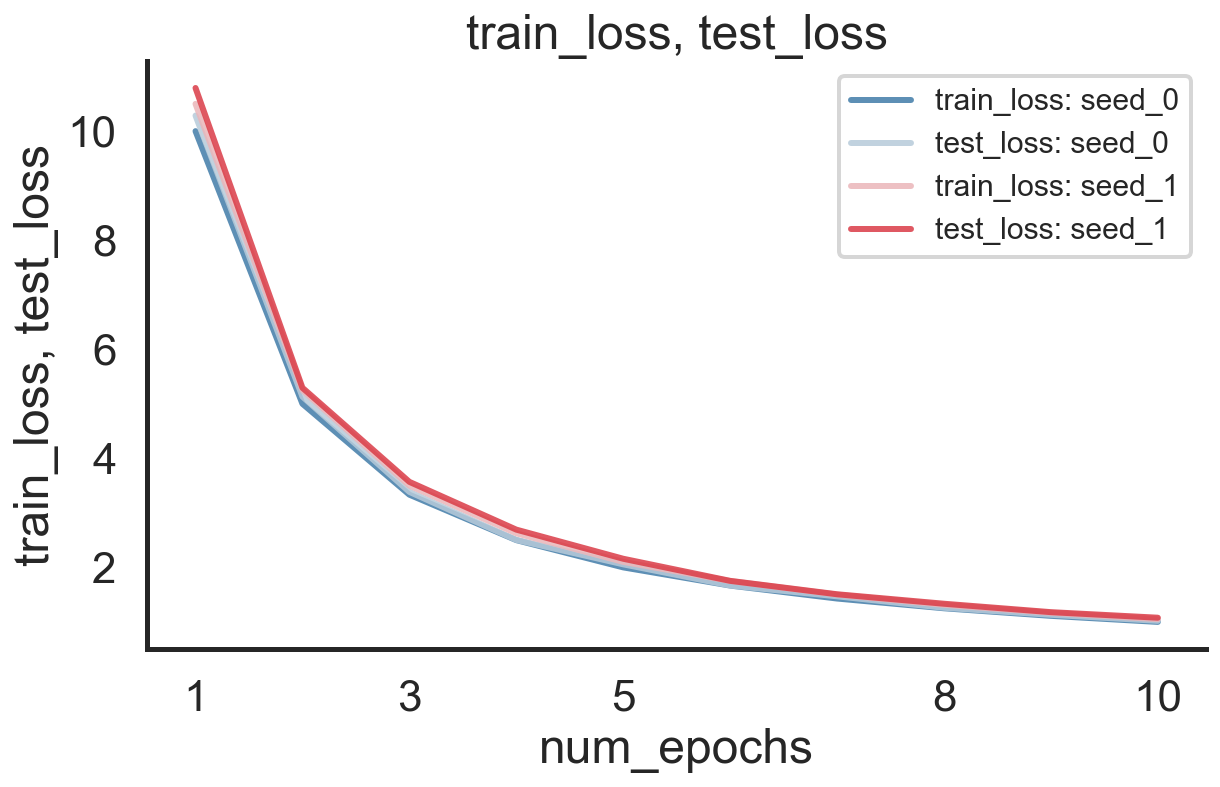

In [14]:
from mle_logging import load_log
import datetime
date = datetime.datetime.today().strftime("%Y-%m-%d")[2:]
log = load_log(f"logs_merge/{date}_base_config_1")
log.plot(["train_loss", "test_loss"])

# Search Jobs with `mle-hyperopt` Configurations

Finally, `mle-scheduler` integrates smoothly with the hyperparameter search tool `mle-hyperopt`. After defining a search strategy, `mle-hyperopt` allows us to get a set of candidate hyperparameters and to export them as configuration files in one go:

In [15]:
try:
    import mle_hyperopt
except:
    !pip install -q mle-hyperopt
    import mle_hyperopt

from mle_hyperopt import RandomSearch

# Instantiate random search class
strategy = RandomSearch(real={"lrate": {"begin": 0.1,
                                        "end": 0.5,
                                        "prior": "log-uniform"}},
                        integer={"batch_size": {"begin": 1,
                                                "end": 5,
                                                "prior": "uniform"}},
                        categorical={"arch": ["mlp", "cnn"]})

# Simple ask - eval - tell API
configs, config_fnames = strategy.ask(2, store=True)
print(f"MLE-Hyperopt Stored Configurations: {config_fnames}")

MLE-Hyperopt Stored Configurations: ['eval_0.yaml', 'eval_1.yaml']


Next we simply forward the configuration filenames to the `MLEQueue` and voilà we have a batch of search configurations running:

In [16]:
queue = MLEQueue(resource_to_run="local",
                 job_filename="train.py",
                 config_filenames=config_fnames,
                 experiment_dir="logs_search")
queue.run()

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.04it/s]     


Give it a try and let me know what you think! If you find a bug or are missing your favourite feature, feel free to contact me [@RobertTLange](https://twitter.com/RobertTLange) or create an issue!

In [23]:
from rich.progress import track
import time

for n in track(range(10), description="MLEQueue Progress"):
    print(n)
    time.sleep(1)

Output()

0
1
2
3
4
5
6
8
9


In [62]:
from rich.progress import (
    BarColumn,
    Progress,
    TextColumn,
    TimeElapsedColumn,
    SpinnerColumn,
)
progress = Progress(SpinnerColumn(),
                    TextColumn("[bold blue]MLEQueue • {task.completed}/{task.total}", justify="left"),
                    BarColumn(bar_width=35, style="magenta"),
                    TextColumn("[progress.percentage]{task.percentage:>3.0f}% •"),
                    TimeElapsedColumn(),
                    TextColumn(":hourglass:", justify="right"))
with progress:
    task = progress.add_task("queue", total=10)
    for job in range(10):
        print(f"Working on job #{job}")
        time.sleep(1)
        progress.advance(task)

Output()

Working on job #0
Working on job #1
Working on job #2
Working on job #3
Working on job #4
Working on job #5
Working on job #6
Working on job #7
Working on job #8
Working on job #9


In [47]:
from rich.progress import (
    BarColumn,
    DownloadColumn,
    Progress,
    TaskID,
    TextColumn,
    TimeRemainingColumn,
    TimeElapsedColumn,
    TransferSpeedColumn,
    SpinnerColumn,
)

progress = Progress(
    TextColumn("[bold blue]{task.fields[filename]}", justify="right"),
    BarColumn(bar_width=None),
    "[progress.percentage]{task.percentage:>3.1f}%",
    "•",
    DownloadColumn(),
    "•",
    TransferSpeedColumn(),
    "•",
    TimeRemainingColumn(),
)